In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from openpyxl.styles.builtins import title
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from itertools import combinations
import yaml
import pandas_datareader.data as web
import os
import re
import requests
import json
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [2]:
dependent_varaibles = [
    'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'
]

In [6]:
bond_yields = pd.read_parquet('data/fred_prorcessed_daily.parquet')
bond_yields = bond_yields[dependent_varaibles]
# get the index values from the data_bonds dataframe
bond_yields_train = bond_yields[bond_yields.index.to_timestamp() < pd.Timestamp('2020-01-01')]
bond_yields_train = bond_yields[bond_yields.index.to_timestamp() >= pd.Timestamp('2011-01-01')]
bond_yields_test = bond_yields[bond_yields.index.to_timestamp() >= pd.Timestamp('2020-01-01')]

print("Training set time period:", bond_yields_train.index.min(), "to", bond_yields_train.index.max())
print("Testing set time period:", bond_yields_test.index.min(), "to", bond_yields_test.index.max())
print(bond_yields_train.shape)

Training set time period: 2011-01-01 to 2024-12-31
Testing set time period: 2020-01-01 to 2024-12-31
(5114, 11)


In [7]:
bond_yields_train.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
period,,,,,,,,,,,
2011-01-01,0.07,0.12,0.19,0.29,0.61,1.02,2.01,2.71,3.30,4.13,4.34
2011-01-02,0.07,0.12,0.19,0.29,0.61,1.02,2.01,2.71,3.30,4.13,4.34
2011-01-03,0.11,0.15,0.19,0.29,0.61,1.03,2.02,2.74,3.36,4.18,4.39
2011-01-04,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,4.21,4.44
2011-01-05,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,4.34,4.55


<Axes: >

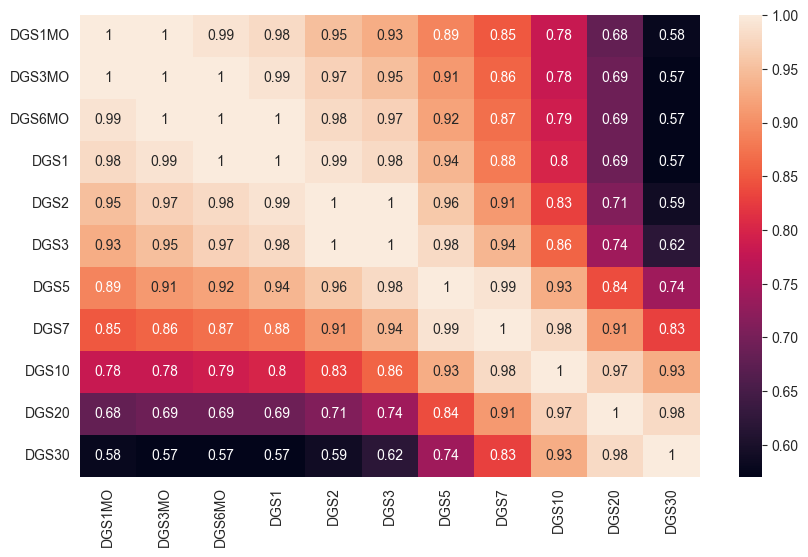

In [9]:
ns_corr = bond_yields_train.corr().round(2)
plt.figure(figsize=(10, 6))
sns.heatmap(data=ns_corr, annot=True, fmt='g')

In [11]:
# load the factor description
factor_description = pd.read_parquet('data/fred_series.parquet')


factors = [
    "1-Year Real Interest Rate",
    "10-Year Expected Inflation",
    "10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity",
    "10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity",
    "10-Year Treasury Constant Maturity Minus Federal Funds Rate",
    "10-Year Breakeven Inflation Rate",
    # "30-Day Average SOFR",
    "30-Year Expected Inflation",
    "2-Year Expected Inflation",
    # "180-Day Average SOFR",
    # "90-Day Average SOFR",
    "CBOE Volatility Index: VIX",
    # "Canadian Dollars to U.S. Dollar Spot Exchange Rate",
    "Effective Federal Funds Rate",
    # "SOFR Index",
    "Federal Surplus or Deficit [-]",
    "Median Consumer Price Index",
    "Smoothed U.S. Recession Probabilities",
    "Sticky Price Consumer Price Index",
    "Total Unemployed, Plus All Persons Marginally Attached to the Labor Force, Plus Total Employed Part Time for Economic Reasons, as a Percent of the Civilian Labor Force Plus All Persons Marginally Attached to the Labor Force (U-6)",
    # "DGS10",
    # "DGS20",
    # "DGS2",
]

factor_ids = factor_description[factor_description["title"].isin(factors)]["id"].tolist()
# make sure the list matches with what was retrieved
assert len(factor_ids) == len(factors)
factor_description[factor_description["title"].isin(factors)][["id", "title"]]


,id,title
485,REAINTRATREARAT1YE,1-Year Real Interest Rate
44,T10YIE,10-Year Breakeven Inflation Rate
415,EXPINF10YR,10-Year Expected Inflation
0,T10Y2Y,10-Year Treasury Constant Maturity Minus 2-Yea...
15,T10Y3M,10-Year Treasury Constant Maturity Minus 3-Mon...
254,T10YFF,10-Year Treasury Constant Maturity Minus Feder...
837,EXPINF2YR,2-Year Expected Inflation
778,EXPINF30YR,30-Year Expected Inflation
215,VIXCLS,CBOE Volatility Index: VIX
165,EFFR,Effective Federal Funds Rate


In [12]:
factor_data = pd.read_parquet('data/fred_prorcessed_daily.parquet')[factor_ids]
factor_data = factor_data.loc[pd.Timestamp('2011-01-01').to_period('D'):]
# get the null count
factor_data.isnull().sum() / factor_data.shape[0]

REAINTRATREARAT1YE     0.0
T10YIE                 0.0
EXPINF10YR             0.0
T10Y2Y                 0.0
T10Y3M                 0.0
T10YFF                 0.0
EXPINF2YR              0.0
EXPINF30YR             0.0
VIXCLS                 0.0
EFFR                   0.0
MTSDS133FMS            0.0
MEDCPIM157SFRBCLE      0.0
RECPROUSM156N          0.0
STICKCPIM158SFRBATL    0.0
U6RATE                 0.0
dtype: float64

In [13]:
# scale the data to single digits if not done already
def scale_to_single_digits(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Scale each column down so the max value is single digits
    """
    # iterate through each column
    for col in cols:
        max_val = df[col].max()
        if pd.isna(max_val) or max_val == 0:
            continue
        scale_factor = 10 ** (len(str(int(max_val))) - 1)
        df.loc[:, col] = ((df[col] / scale_factor) / 10).round(5)
        # df[col].describe()
    return df

factor_data = scale_to_single_digits(df=factor_data, cols=factor_data.columns)
factor_data.describe()

,REAINTRATREARAT1YE,T10YIE,EXPINF10YR,T10Y2Y,T10Y3M,T10YFF,EXPINF2YR,EXPINF30YR,VIXCLS,EFFR,MTSDS133FMS,MEDCPIM157SFRBCLE,RECPROUSM156N,STICKCPIM158SFRBATL,U6RATE
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000
mean,-0.036937,0.205395,0.182853,0.091232,0.112315,0.114356,0.178591,0.215733,0.179875,0.130524,-0.107625,0.025451,0.001412,0.292710,0.103036
std,0.187413,0.035357,0.028868,0.091561,0.124087,0.118187,0.047275,0.016765,0.069022,0.175117,0.154870,0.012037,0.010837,0.158233,0.033447
min,-0.396640,0.050000,0.115830,-0.108000,-0.189000,-0.171000,0.042400,0.178340,0.091400,0.004000,-0.864070,0.009490,0.000000,-0.175550,0.066000
25%,-0.153350,0.180000,0.163000,0.021000,0.032000,0.051000,0.148020,0.203400,0.133725,0.009000,-0.192610,0.017640,0.000040,0.202160,0.074000
50%,-0.087315,0.212000,0.180780,0.093000,0.141000,0.138000,0.169510,0.215880,0.161400,0.030000,-0.106530,0.021460,0.000120,0.254820,0.095500
75%,0.063285,0.231000,0.204830,0.155000,0.198000,0.194000,0.204850,0.228323,0.206000,0.192000,-0.023190,0.028063,0.000260,0.341390,0.127750
max,0.800560,0.302000,0.245470,0.291000,0.360000,0.359000,0.318170,0.251220,0.826900,0.533000,0.308220,0.065830,0.100000,0.842170,0.229000


In [14]:
# merge the factor data with the nelson siegel params data
print(f"Shape prior: {bond_yields_train.shape}")
bond_yields_train = bond_yields_train.merge(factor_data, left_index=True, right_index=True, how='left')
print(f"Shape of new data: {bond_yields_train.shape}")
print(f"Null Count \n {bond_yields_train.isnull().sum()}")

Shape prior: (5114, 11)
Shape of new data: (5114, 26)
Null Count 
 DGS1MO                 0
DGS3MO                 0
DGS6MO                 0
DGS1                   0
DGS2                   0
DGS3                   0
DGS5                   0
DGS7                   0
DGS10                  0
DGS20                  0
DGS30                  0
REAINTRATREARAT1YE     0
T10YIE                 0
EXPINF10YR             0
T10Y2Y                 0
T10Y3M                 0
T10YFF                 0
EXPINF2YR              0
EXPINF30YR             0
VIXCLS                 0
EFFR                   0
MTSDS133FMS            0
MEDCPIM157SFRBCLE      0
RECPROUSM156N          0
STICKCPIM158SFRBATL    0
U6RATE                 0
dtype: int64


In [15]:
bond_yields_train.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,...,T10YFF,EXPINF2YR,EXPINF30YR,VIXCLS,EFFR,MTSDS133FMS,MEDCPIM157SFRBCLE,RECPROUSM156N,STICKCPIM158SFRBATL,U6RATE
period,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.07,0.12,0.19,0.29,0.61,1.02,2.01,2.71,3.30,4.13,...,0.317,0.17789,0.22586,0.1775,0.013,-0.0498,0.01875,0.00002,0.21378,0.161
2011-01-02,0.07,0.12,0.19,0.29,0.61,1.02,2.01,2.71,3.30,4.13,...,0.317,0.17789,0.22586,0.1775,0.013,-0.0498,0.01875,0.00002,0.21378,0.161
2011-01-03,0.11,0.15,0.19,0.29,0.61,1.03,2.02,2.74,3.36,4.18,...,0.317,0.17789,0.22586,0.1761,0.019,-0.0498,0.01875,0.00002,0.21378,0.161
2011-01-04,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,4.21,...,0.318,0.17789,0.22586,0.1738,0.018,-0.0498,0.01875,0.00002,0.21378,0.161
2011-01-05,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,4.34,...,0.332,0.17789,0.22586,0.1702,0.018,-0.0498,0.01875,0.00002,0.21378,0.161


In [17]:
dependent_varaibles
bond_yields_train_shifted_1 = bond_yields_train.copy()
bond_yields_train_shifted_7 = bond_yields_train.copy()
bond_yields_train_shifted_30 = bond_yields_train.copy()
bond_yields_train_shifted_60 = bond_yields_train.copy()

for dependent_varaible in dependent_varaibles:
    bond_yields_train_shifted_1[f"{dependent_varaible}_future_val"] = bond_yields_train_shifted_1[dependent_varaible].shift(-1)
    bond_yields_train_shifted_7[f"{dependent_varaible}_future_val"] = bond_yields_train_shifted_7[dependent_varaible].shift(-7)
    bond_yields_train_shifted_30[f"{dependent_varaible}_future_val"] = bond_yields_train_shifted_30[dependent_varaible].shift(-30)
    bond_yields_train_shifted_60[f"{dependent_varaible}_future_val"] = bond_yields_train_shifted_60[dependent_varaible].shift(-60)


print(f"Null values 1 day: {bond_yields_train_shifted_1.isna().sum()}")
print(f"Null values 7 day: {bond_yields_train_shifted_7.isna().sum()}")
print(f"Null values 30 day: {bond_yields_train_shifted_30.isna().sum()}")
print(f"Null values 60 day: {bond_yields_train_shifted_60.isna().sum()}")

bond_yields_train_shifted_60.tail()

Null values 1 day: DGS1MO                 0
DGS3MO                 0
DGS6MO                 0
DGS1                   0
DGS2                   0
DGS3                   0
DGS5                   0
DGS7                   0
DGS10                  0
DGS20                  0
DGS30                  0
REAINTRATREARAT1YE     0
T10YIE                 0
EXPINF10YR             0
T10Y2Y                 0
T10Y3M                 0
T10YFF                 0
EXPINF2YR              0
EXPINF30YR             0
VIXCLS                 0
EFFR                   0
MTSDS133FMS            0
MEDCPIM157SFRBCLE      0
RECPROUSM156N          0
STICKCPIM158SFRBATL    0
U6RATE                 0
DGS1MO_future_val      1
DGS3MO_future_val      1
DGS6MO_future_val      1
DGS1_future_val        1
DGS2_future_val        1
DGS3_future_val        1
DGS5_future_val        1
DGS7_future_val        1
DGS10_future_val       1
DGS20_future_val       1
DGS30_future_val       1
dtype: int64
Null values 7 day: DGS1MO                 0

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,...,DGS3MO_future_val,DGS6MO_future_val,DGS1_future_val,DGS2_future_val,DGS3_future_val,DGS5_future_val,DGS7_future_val,DGS10_future_val,DGS20_future_val,DGS30_future_val
period,,,,,,,,,,,,,,,,,,,,,
2024-12-27,4.44,4.31,4.29,4.20,4.31,4.36,4.45,4.53,4.62,4.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-28,4.44,4.31,4.29,4.20,4.31,4.36,4.45,4.53,4.62,4.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,4.44,4.31,4.29,4.20,4.31,4.36,4.45,4.53,4.62,4.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,4.43,4.37,4.25,4.17,4.24,4.29,4.37,4.46,4.55,4.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-31,4.40,4.37,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# for each factor create lags 1, 7, 30, and 60
data_sets = [
    bond_yields_train_shifted_1,
    bond_yields_train_shifted_7,
    bond_yields_train_shifted_30,
    bond_yields_train_shifted_60
]
new_data = []
factor_ids = factor_ids + ['2yr_10yr_spread', '2yr_10yr_spread']
for data in tqdm(data_sets, desc="Creating feature engineered feature for Each dataset"):
    # merge the DGS values to the data
    # data = data.merge(bond_yields_train[["DGS2", "DGS10", "DGS20"]], left_index=True, right_index=True, how='left')
    # scale the dependent variables by 100
    data[dependent_varaibles] = data[dependent_varaibles] / 100.0
    data['2yr_10yr_spread'] = data['DGS10'] - data['DGS2']
    data['2yr_10yr_spread'] = data['DGS20'] - data['DGS2']
    # scale the calculated columns
    # data = scale_to_single_digits(df=data, cols=["DGS2", "DGS10", "DGS20", '2yr_10yr_spread', '2yr_10yr_spread'])
    for factor in factor_ids:
        # create transition columns for each factor
        data[f'{factor}_transition_1'] = data[factor] - data[factor].shift(1)
        data[f'{factor}_transition_7'] = data[factor] - data[factor].shift(7)
        data[f'{factor}_transition_30'] = data[factor] - data[factor].shift(30)
        data[f'{factor}_transition_60'] = data[factor] - data[factor].shift(60)
        # create moving averages
        data[f'{factor}_moving_avg_30'] = data[factor].rolling(window=30).mean()
        data[f'{factor}_moving_avg_60'] = data[factor].rolling(window=60).mean()
        # create exponential moving averages
        data[f'{factor}_exp_moving_avg_30'] = data[factor].ewm(span=30, adjust=False).mean()
        data[f'{factor}_exp_moving_avg_60'] = data[factor].ewm(span=60, adjust=False).mean()
    new_data.append(data)

bond_yields_train_shifted_1 = new_data[0]
bond_yields_train_shifted_7 = new_data[1]
bond_yields_train_shifted_30 = new_data[2]
bond_yields_train_shifted_60 = new_data[3]
print(f"Shape of 1 day shift data: {bond_yields_train_shifted_1.shape}")
print(f"Shape of 7 day shift data: {bond_yields_train_shifted_7.shape}")
print(f"Shape of 30 day shift data: {bond_yields_train_shifted_30.shape}")
print(f"Shape of 60 day shift data: {bond_yields_train_shifted_60.shape}")

Creating feature engineered feature for Each dataset:   0%|          | 0/4 [00:00<?, ?it/s]/var/folders/h3/n4kr77l914l79rj692skv4jw0000gn/T/ipykernel_32297/727629405.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{factor}_moving_avg_30'] = data[factor].rolling(window=30).mean()
/var/folders/h3/n4kr77l914l79rj692skv4jw0000gn/T/ipykernel_32297/727629405.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{factor}_moving_avg_60'] = data[factor].rolling(window=60).mean()
/var/folders/h3/n4kr77l914l79rj692skv4jw0

Shape of 1 day shift data: (5114, 166)
Shape of 7 day shift data: (5114, 166)
Shape of 30 day shift data: (5114, 166)
Shape of 60 day shift data: (5114, 166)


In [19]:
bond_yields_train_shifted_1.to_parquet('data/bond_yields_train_shifted_1.parquet')
bond_yields_train_shifted_7.to_parquet('data/bond_yields_train_shifted_7.parquet')
bond_yields_train_shifted_30.to_parquet('data/bond_yields_train_shifted_30.parquet')
bond_yields_train_shifted_60.to_parquet('data/bond_yields_train_shifted_60.parquet')
print('Data saved')

Data saved


## Correlation Analysis

In [107]:
# load the data
bond_yields_train_shifted_1 = pd.read_parquet('data/bond_yields_train_shifted_1.parquet')
bond_yields_train_shifted_7 = pd.read_parquet('data/bond_yields_train_shifted_7.parquet')
bond_yields_train_shifted_30 = pd.read_parquet('data/bond_yields_train_shifted_30.parquet')
bond_yields_train_shifted_60 = pd.read_parquet('data/bond_yields_train_shifted_60.parquet')
# find the correlation between the factors and the dependent variables
# get the correlations between the independent variables and each dependent variable
dependent_variables = [x for x in bond_yields_train_shifted_30.columns if "_future_val" in x]
data_sets = [
    bond_yields_train_shifted_1,
    bond_yields_train_shifted_7,
    bond_yields_train_shifted_30,
    bond_yields_train_shifted_60
]

df_correlations = []
for data in tqdm(data_sets, desc="Finding Correlation between Dependent and Independent Variables"):
    rows = []
    counter = 0
    for dependent_var in dependent_variables:
        independent_cols = [x for x in data.columns if x not in dependent_variables]
        # print(f"Dependent variable: {dependent_var}: {independent_cols}")
        for independent_var in independent_cols:
            # get the correlation value between the two variables
            try:
                corr_val = data[[dependent_var, independent_var]].dropna().corr()
                corr_val = corr_val.loc[dependent_var, independent_var]
                # print(f"Correlation between {dependent_var} and {independent_var}: {corr_val}")
                rows.append({
                    'dependent_variable': dependent_var,
                    'independent_variable': independent_var,
                    'correlation': corr_val
                })
            except Exception as e:
                continue

    df_correlation = pd.DataFrame(rows)
    df_correlations.append(df_correlation)

df_correlation1 = df_correlations[0]
df_correlation7 = df_correlations[1]
df_correlation30 = df_correlations[2]
df_correlation60 = df_correlations[3]
# # get the groupby count by dependent_variable
df_correlation_count = df_correlation1['dependent_variable'].value_counts().reset_index()
df_correlation_count.columns = ['dependent_variable', 'count']
df_correlation_count = df_correlation_count.sort_values(by='count', ascending=False)
df_correlation_count.head(15)

Finding Correlation between Dependent and Independent Variables: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


,dependent_variable,count
0,DGS1MO_future_val,155
1,DGS3MO_future_val,155
2,DGS6MO_future_val,155
3,DGS1_future_val,155
4,DGS2_future_val,155
5,DGS3_future_val,155
6,DGS5_future_val,155
7,DGS7_future_val,155
8,DGS10_future_val,155
9,DGS20_future_val,155


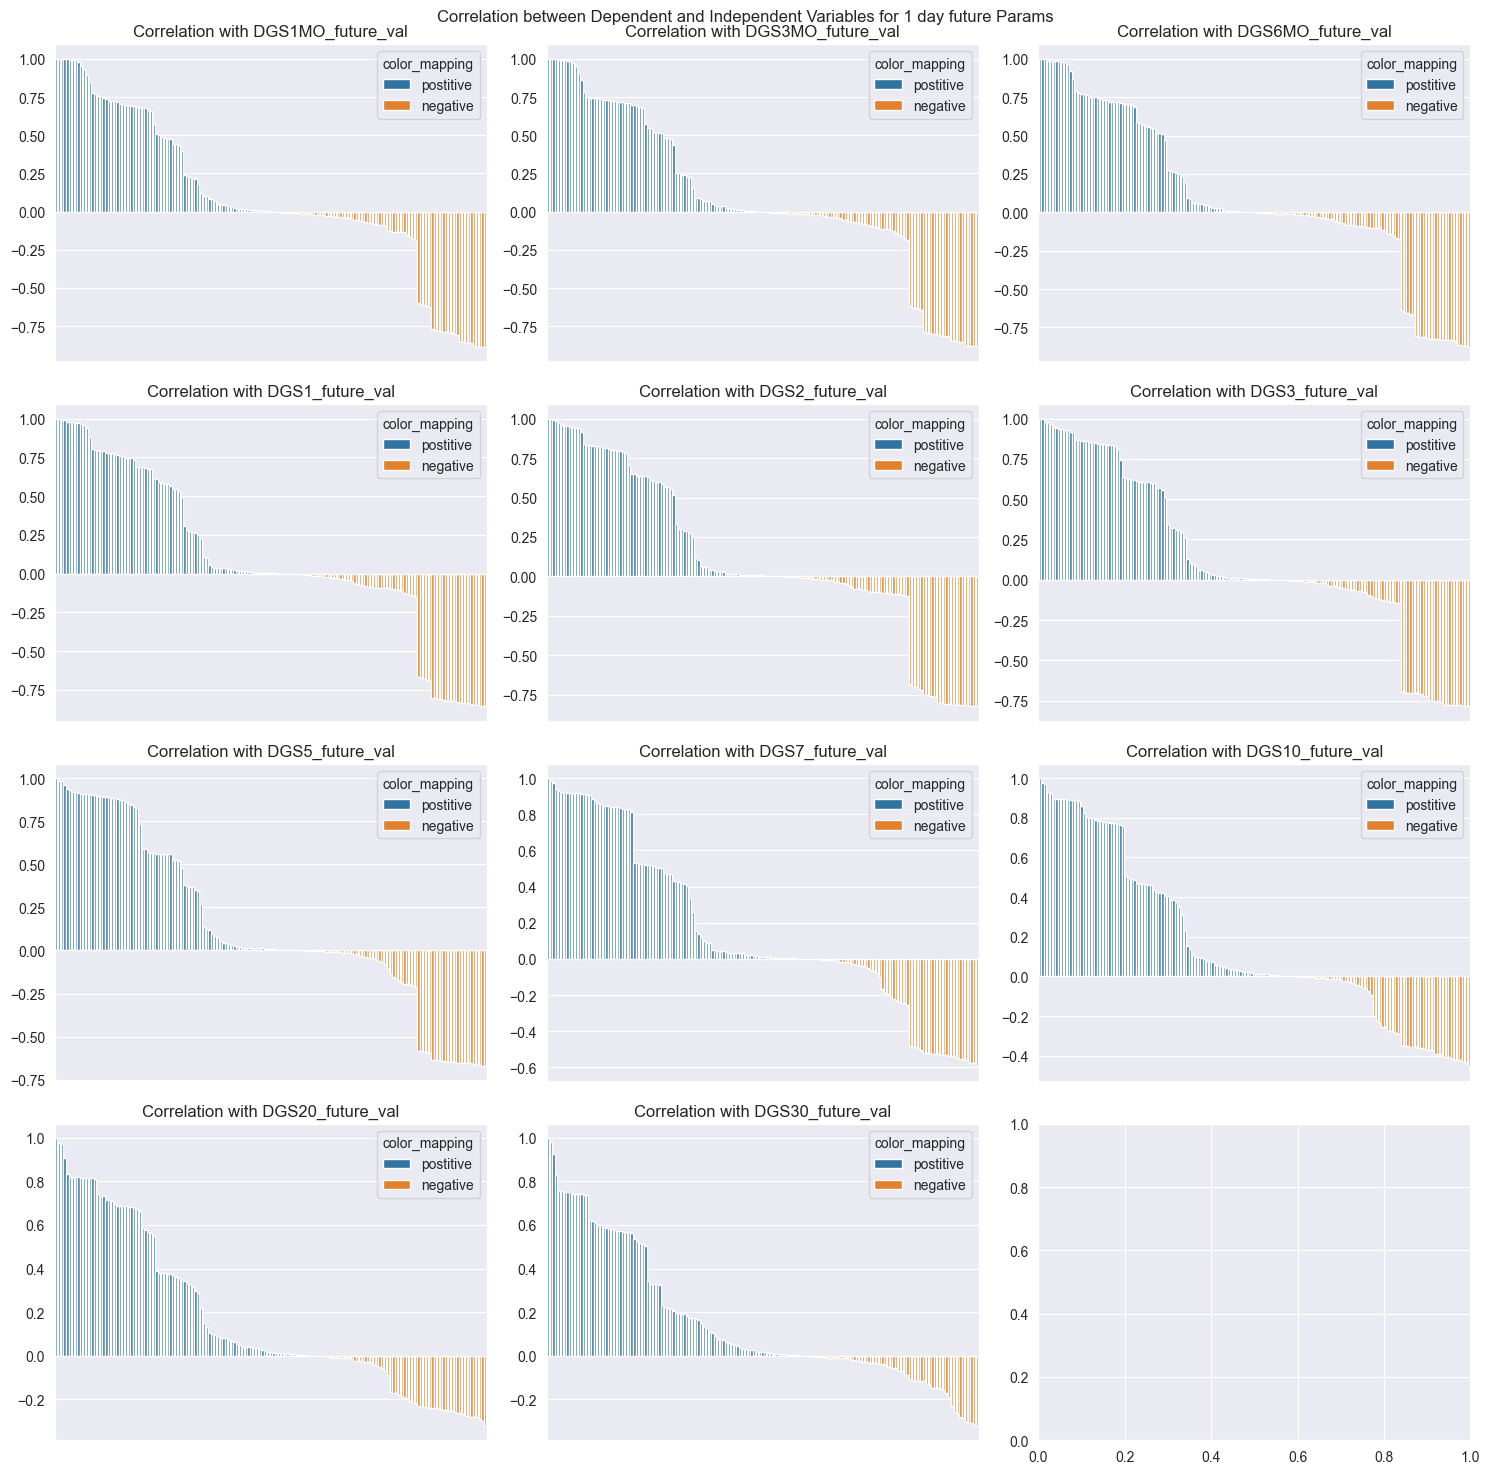

In [108]:
# Sort the correlation dataframe by correlation value in descending order
df_correlation_sorted = df_correlation1.sort_values(by='correlation', ascending=False)
df_correlation_sorted['color_mapping'] = df_correlation_sorted['correlation'].apply(lambda x: 'postitive' if x > 0 else 'negative')
# Plot the correlation values using seaborn barplot. Remove x labels. Use green for correlations above 0 and red for those less than. Do this for each dependent variable by creating a 6 by 6 subplot

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
for i, dependent_var in enumerate(dependent_variables):
    df_tmp = df_correlation_sorted[df_correlation_sorted['dependent_variable'] == dependent_var]
    sns.barplot(data=df_tmp, x='independent_variable', y='correlation', hue='color_mapping', ax=axes[i])
    axes[i].set_title(f'Correlation with {dependent_var}')
    # remove xticks
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle('Correlation between Dependent and Independent Variables for 1 day future Params')
plt.tight_layout()

In [29]:
df_correlation1['correlation'] = pd.to_numeric(df_correlation1['correlation'], errors='coerce')
df_correlation7['correlation'] = pd.to_numeric(df_correlation7['correlation'], errors='coerce')
df_correlation30['correlation'] = pd.to_numeric(df_correlation30['correlation'], errors='coerce')
df_correlation60['correlation'] = pd.to_numeric(df_correlation60['correlation'], errors='coerce')


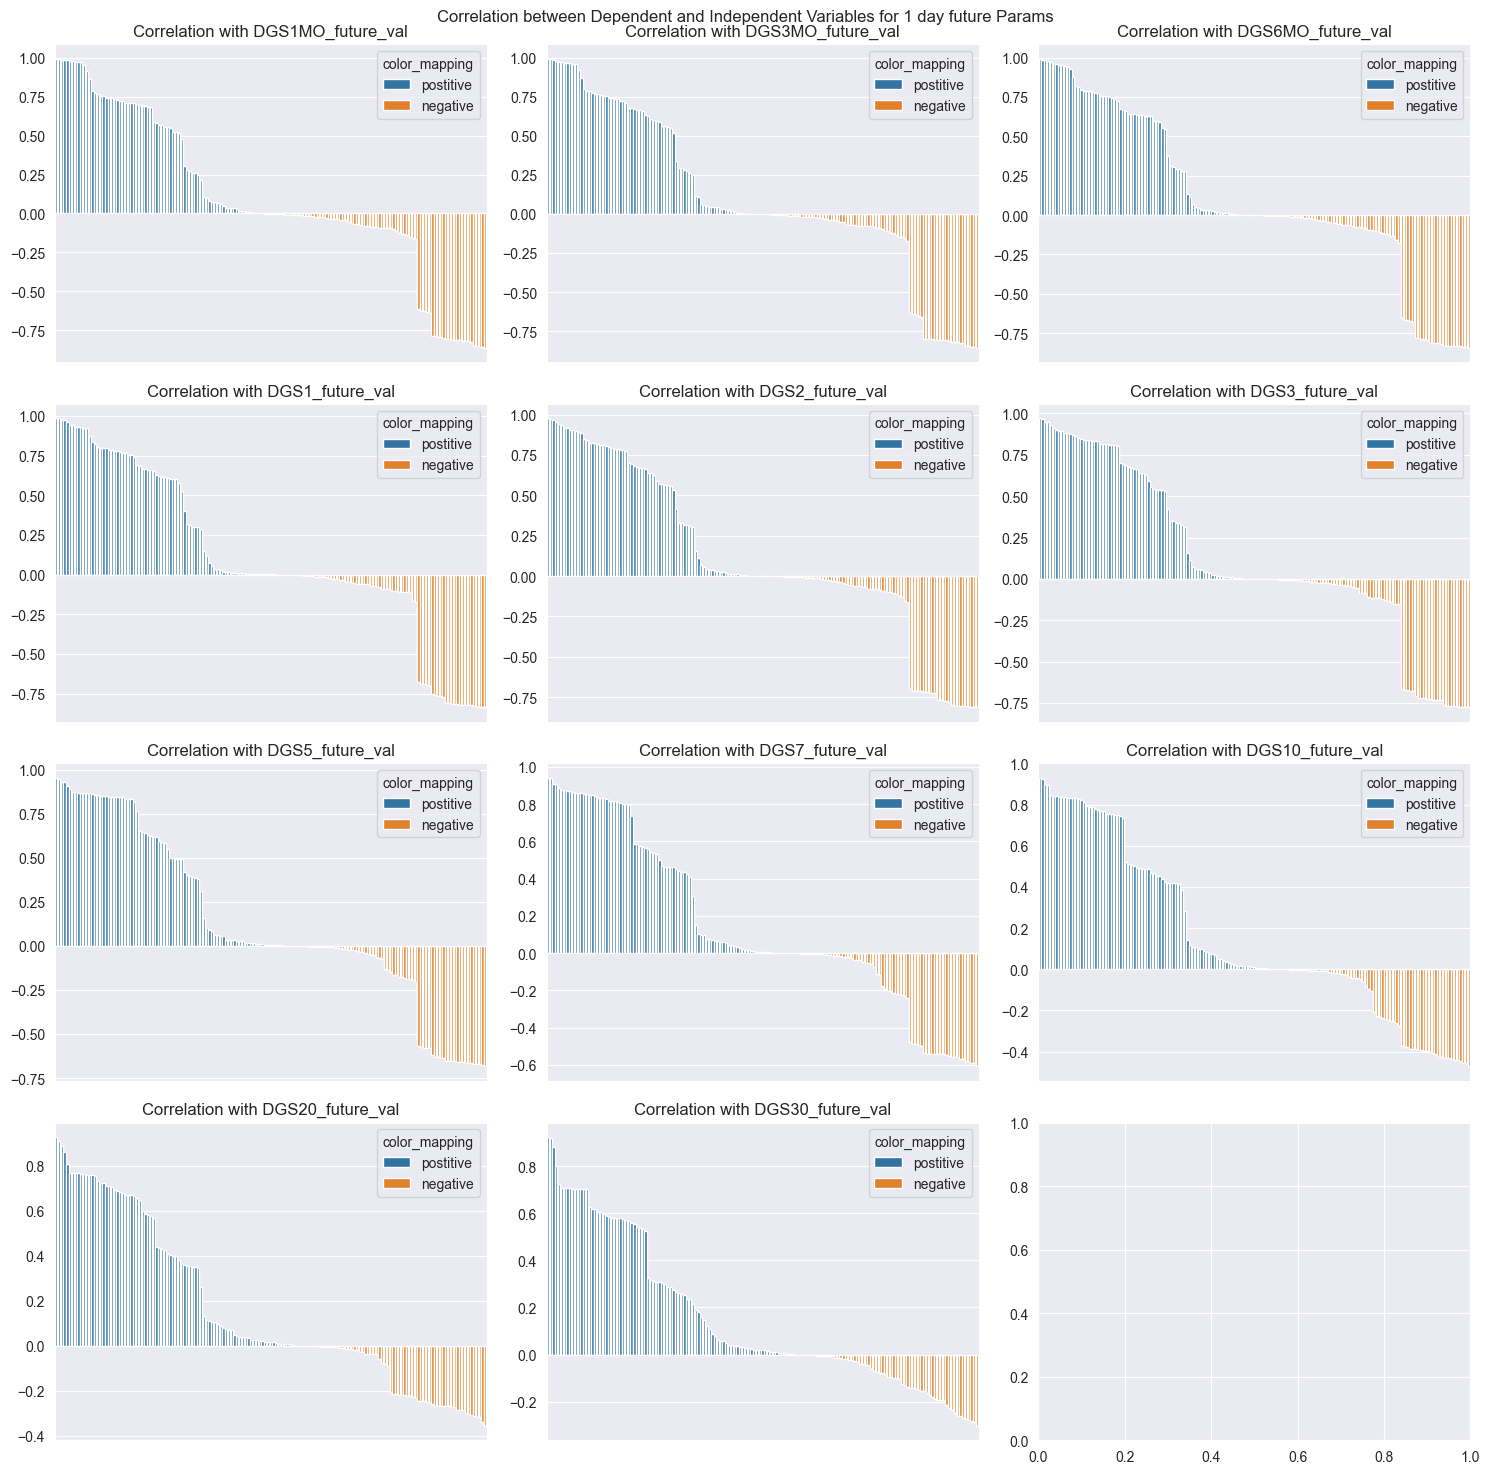

In [109]:
df_correlation_sorted = df_correlation60.sort_values(by='correlation', ascending=False)
df_correlation_sorted['color_mapping'] = df_correlation_sorted['correlation'].apply(lambda x: 'postitive' if x > 0 else 'negative')
# Plot the correlation values using seaborn barplot. Remove x labels. Use green for correlations above 0 and red for those less than. Do this for each dependent variable by creating a 6 by 6 subplot

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
for i, dependent_var in enumerate(dependent_variables):
    df_tmp = df_correlation_sorted[df_correlation_sorted['dependent_variable'] == dependent_var]
    sns.barplot(data=df_tmp, x='independent_variable', y='correlation', hue='color_mapping', ax=axes[i])
    axes[i].set_title(f'Correlation with {dependent_var}')
    # remove xticks
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle('Correlation between Dependent and Independent Variables for 1 day future Params')
plt.tight_layout()

In [110]:
# get the variables with a correlation above or below 0.5 or -0.5 for each dataset
one_day_ahead_correlated_features = df_correlation1[(df_correlation1['correlation'] >= 0.6) | (df_correlation1['correlation'] <= -0.6)]["independent_variable"].unique()
seven_day_ahead_correlated_features = df_correlation7[(df_correlation7['correlation'] >= 0.6) | (df_correlation7['correlation'] <= -0.6)]["independent_variable"].unique()
thirty_day_ahead_correlated_features = df_correlation30[(df_correlation30['correlation'] >= 0.6) | (df_correlation30['correlation'] <= -0.6)]["independent_variable"].unique()
sixty_day_ahead_correlated_features = df_correlation60[(df_correlation60['correlation'] >= 0.6) | (df_correlation60['correlation'] <= -0.6)]["independent_variable"].unique()

one_day_ahead_correlated_features = list(set(one_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})
seven_day_ahead_correlated_features = list(set(seven_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})
thirty_day_ahead_correlated_features = list(set(thirty_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})
sixty_day_ahead_correlated_features = list(set(sixty_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})


print(f"One day ahead correlated features: {len(one_day_ahead_correlated_features)}")
print(f"Seven day ahead correlated features: {len(seven_day_ahead_correlated_features)}")
print(f"Thirty day ahead correlated features: {len(thirty_day_ahead_correlated_features)}")
print(f"Sixty day ahead correlated features: {len(sixty_day_ahead_correlated_features)}")

One day ahead correlated features: 66
Seven day ahead correlated features: 67
Thirty day ahead correlated features: 69
Sixty day ahead correlated features: 70


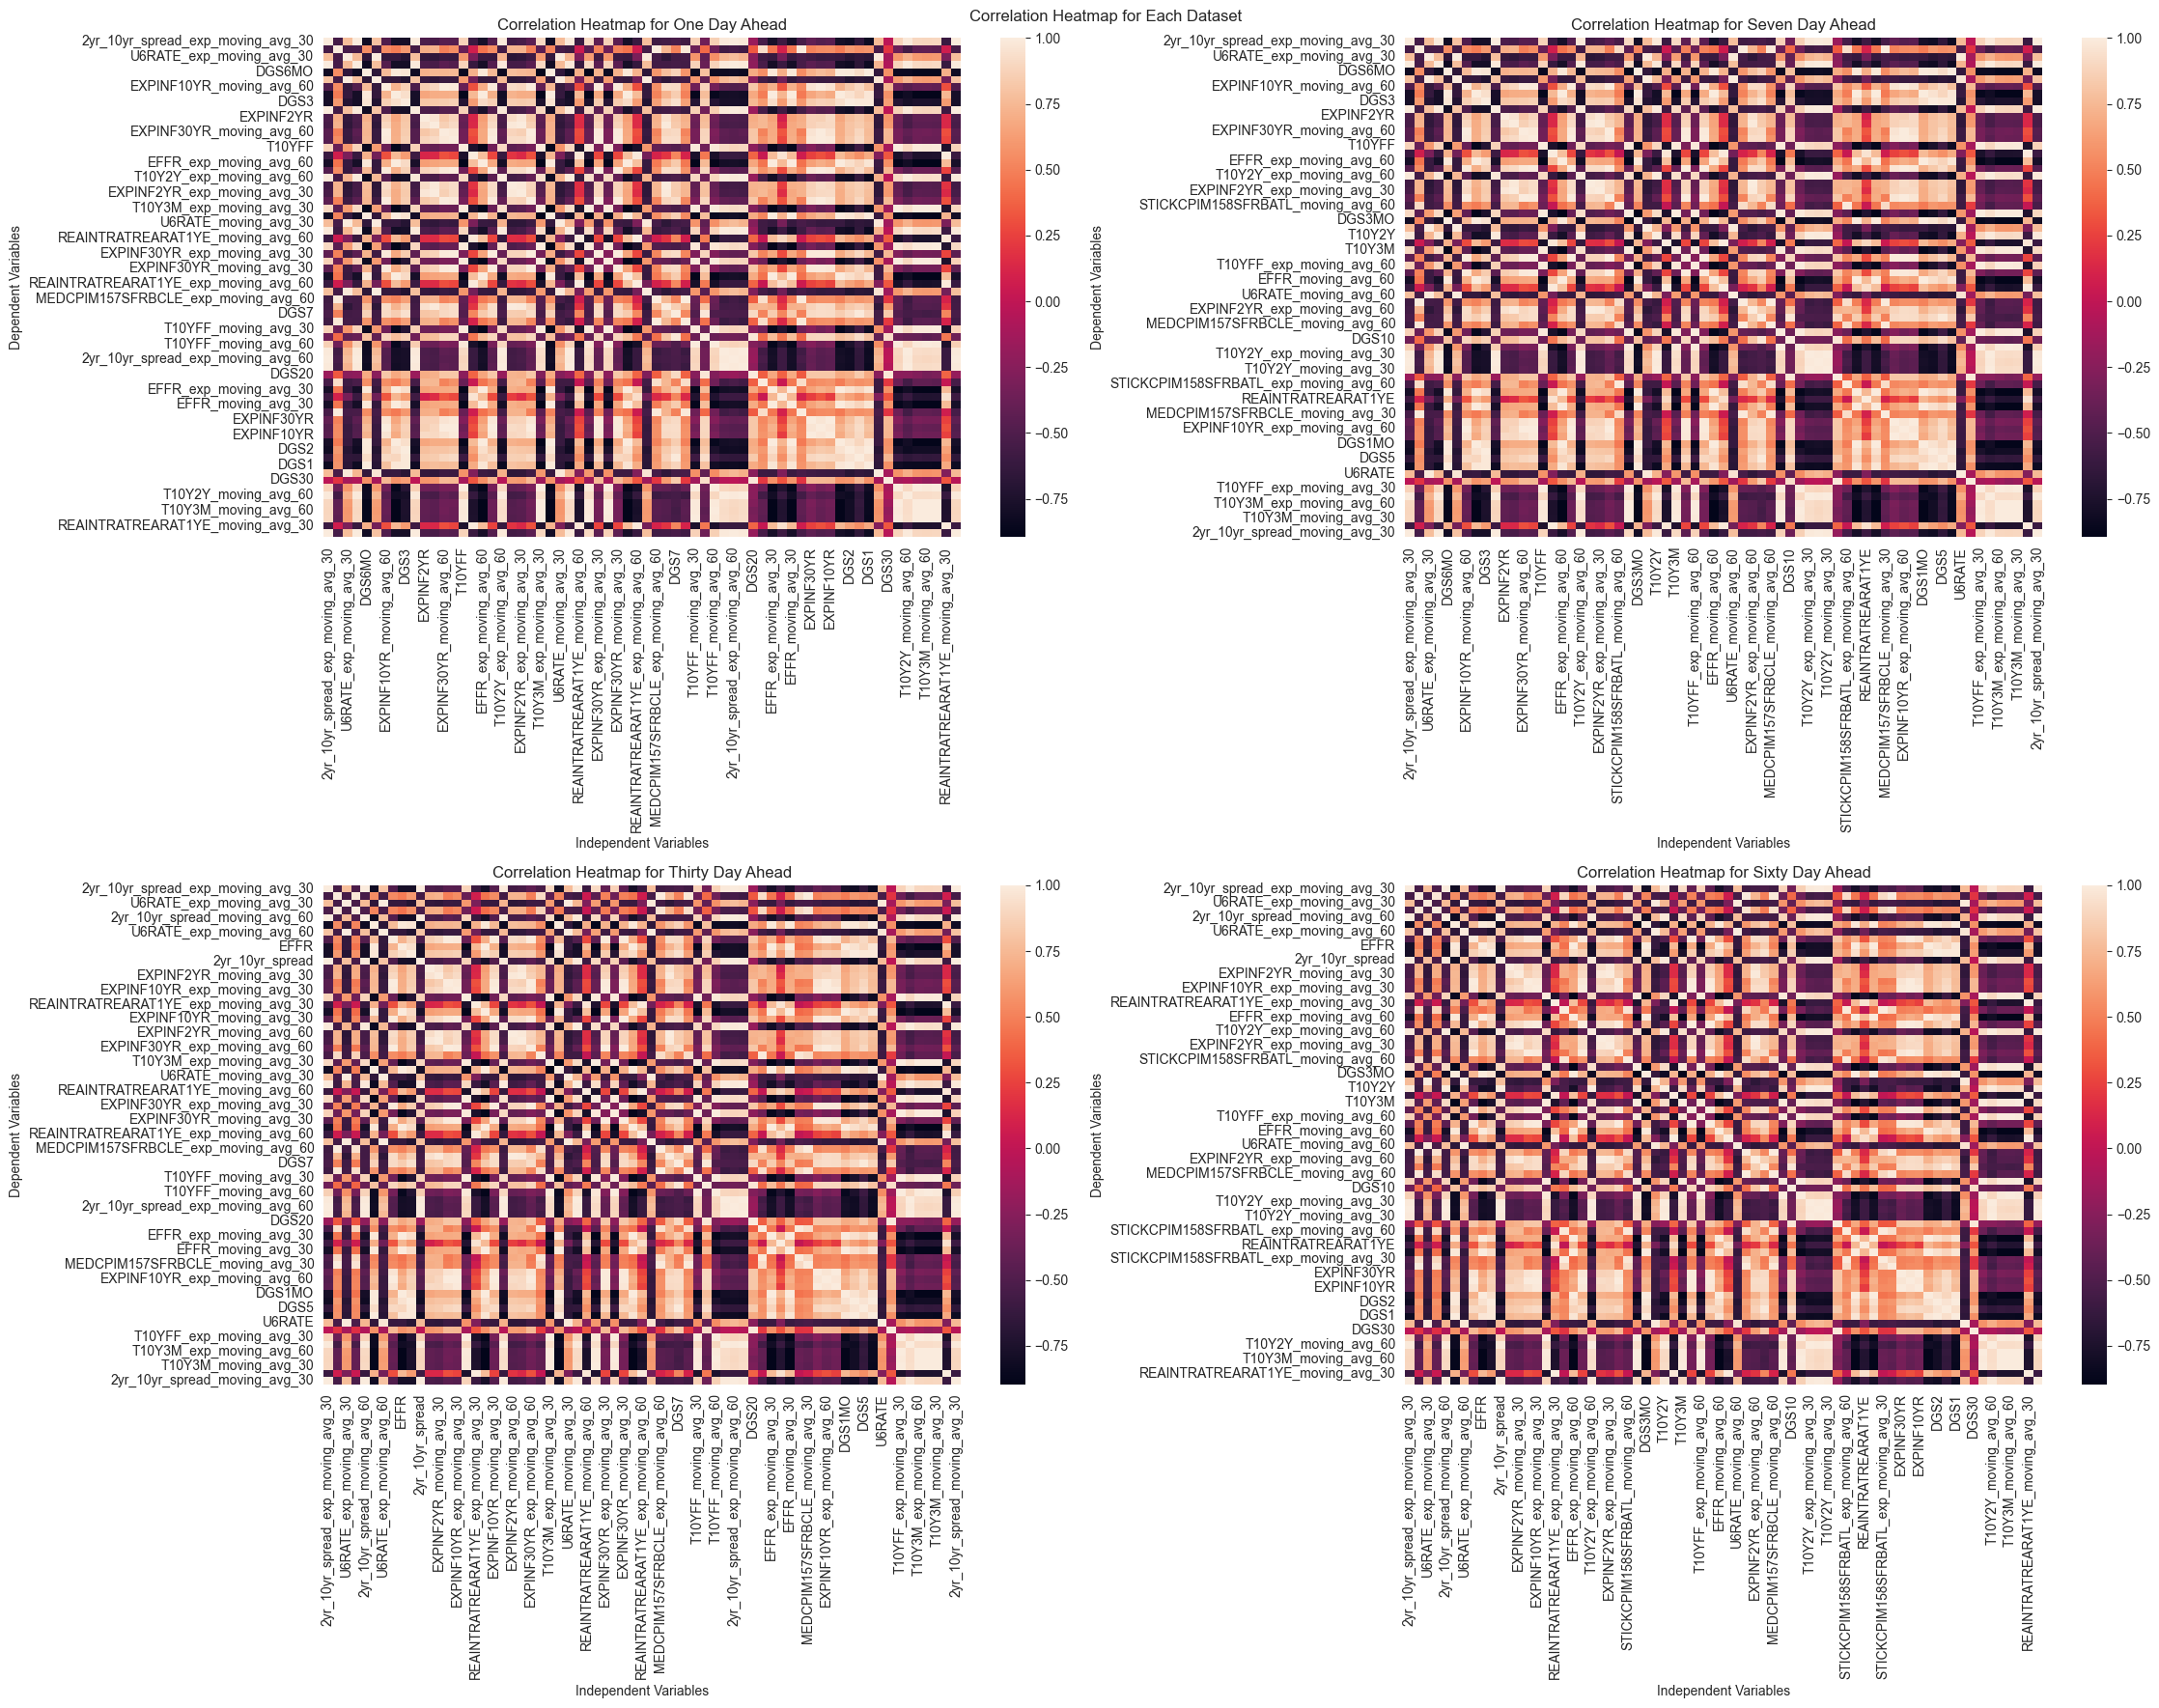

In [111]:
# plot the correlation heatmap of the for each datasets' independent variables
data_sets = [
    bond_yields_train_shifted_1,
    bond_yields_train_shifted_7,
    bond_yields_train_shifted_30,
    bond_yields_train_shifted_60
]

correlated_features = [one_day_ahead_correlated_features, seven_day_ahead_correlated_features, thirty_day_ahead_correlated_features, sixty_day_ahead_correlated_features]
titles = ['One Day Ahead', 'Seven Day Ahead', 'Thirty Day Ahead', 'Sixty Day Ahead']
fig, axes = plt.subplots(2, 2, figsize=(23, 18))
axes = axes.flatten()
for i, data in enumerate(zip(data_sets, correlated_features, titles)):
    data_vals = data[0]
    ind_cols = data[1]
    title = data[2]
    sns.heatmap(data_vals[ind_cols].corr(), annot=False, ax=axes[i])
    axes[i].set_title(f'Correlation Heatmap for {title}')
    axes[i].set_xlabel('Independent Variables')
    axes[i].set_ylabel('Dependent Variables')
plt.suptitle('Correlation Heatmap for Each Dataset')
plt.tight_layout()

In [112]:
# get the avg correlation for each independent variable for each dataset
df_correlation1_avg = df_correlation1[df_correlation1['independent_variable'].isin(one_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
df_correlation7_avg = df_correlation7[df_correlation7['independent_variable'].isin(seven_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
df_correlation30_avg = df_correlation30[df_correlation30['independent_variable'].isin(thirty_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
df_correlation60_avg = df_correlation60[df_correlation60['independent_variable'].isin(sixty_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
# pivot the df correlation data so the dependent varibales values are columns, the corresponding coefficients are the column values, and is indexed by the independent variable
df_correlation1_avg = df_correlation1[df_correlation1['independent_variable'].isin(one_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')
df_correlation7_avg = df_correlation7[df_correlation7['independent_variable'].isin(seven_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')
df_correlation30_avg = df_correlation30[df_correlation30['independent_variable'].isin(thirty_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')
df_correlation60_avg = df_correlation60[df_correlation60['independent_variable'].isin(sixty_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')

# # create a weighted avg columns that takes the row wise average by applying the following weights for each column, beta0 = 0.2 beta1 = 0.4 beta2 = 0.3 lambda = 0.1
# weights = {'beta0': 0.2, 'beta1': 0.4, 'beta2': 0.3, 'lambda': 0.1}
#
# df_correlation1_avg['weighted_avg'] = (
#     df_correlation1_avg['beta0_future_val'] * weights['beta0'] +
#     df_correlation1_avg['beta1_future_val'] * weights['beta1'] +
#     df_correlation1_avg['beta2_future_val'] * weights['beta2'] +
#     df_correlation1_avg['lambda_future_val'] * weights['lambda']
# )

df_correlation1_avg.head()

dependent_variable,DGS10_future_val,DGS1MO_future_val,DGS1_future_val,DGS20_future_val,DGS2_future_val,DGS30_future_val,DGS3MO_future_val,DGS3_future_val,DGS5_future_val,DGS6MO_future_val,DGS7_future_val
independent_variable,,,,,,,,,,,
2yr_10yr_spread,-0.350246,-0.771634,-0.820923,-0.165641,-0.812617,-0.012567,-0.789192,-0.778457,-0.654717,-0.807334,-0.526527
2yr_10yr_spread_exp_moving_avg_30,-0.352348,-0.777258,-0.822589,-0.169543,-0.812576,-0.017387,-0.793950,-0.777734,-0.654053,-0.810607,-0.526983
2yr_10yr_spread_exp_moving_avg_60,-0.353395,-0.782198,-0.823386,-0.172358,-0.811611,-0.021112,-0.797796,-0.775983,-0.652492,-0.812878,-0.526438
2yr_10yr_spread_moving_avg_30,-0.368903,-0.779374,-0.824678,-0.190614,-0.815164,-0.038874,-0.796048,-0.781299,-0.661635,-0.812658,-0.538737
2yr_10yr_spread_moving_avg_60,-0.391331,-0.786566,-0.828131,-0.219332,-0.818302,-0.068932,-0.802465,-0.785667,-0.671568,-0.817301,-0.554627


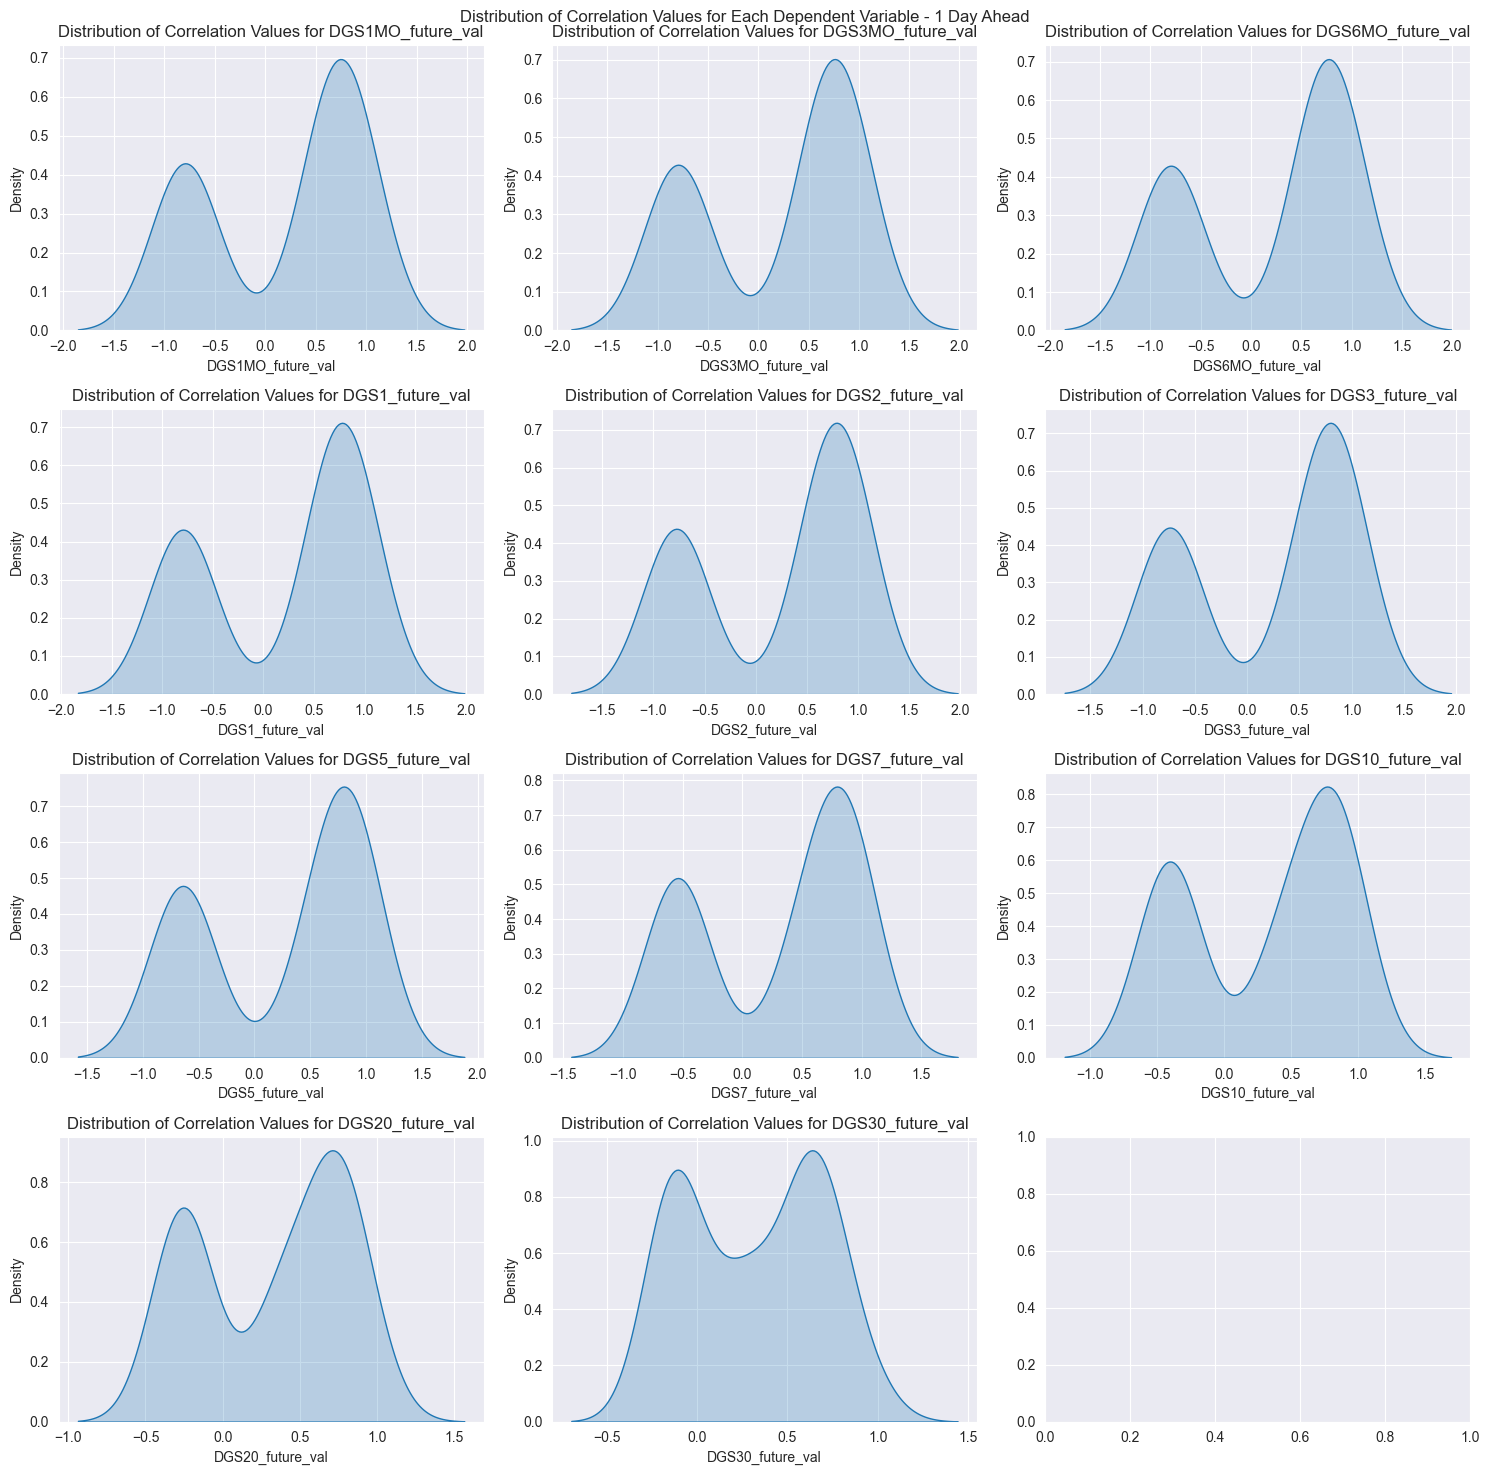

In [113]:
# Get the distrinbution of correlation values for each dataset
ploting_df = df_correlation30_avg
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(dependent_variables):
    sns.kdeplot(ploting_df, x=var, ax=axes[i], fill=True)
    axes[i].set_title(f'Distribution of Correlation Values for {var}')
plt.suptitle('Distribution of Correlation Values for Each Dependent Variable - 1 Day Ahead')
plt.tight_layout()
plt.show()

In [121]:
# get the row avg as the correlation avg column
df_correlation1_avg['correlation_avg'] = df_correlation1_avg.mean(axis=1)
df_correlation7_avg['correlation_avg'] = df_correlation7_avg.mean(axis=1)
df_correlation30_avg['correlation_avg'] = df_correlation30_avg.mean(axis=1)
df_correlation60_avg['correlation_avg'] = df_correlation60_avg.mean(axis=1)

df_correlation1_avg.head()

dependent_variable,DGS10_future_val,DGS1MO_future_val,DGS1_future_val,DGS20_future_val,DGS2_future_val,DGS30_future_val,DGS3MO_future_val,DGS3_future_val,DGS5_future_val,DGS6MO_future_val,DGS7_future_val,correlation_avg
independent_variable,,,,,,,,,,,,
2yr_10yr_spread,-0.350246,-0.771634,-0.820923,-0.165641,-0.812617,-0.012567,-0.789192,-0.778457,-0.654717,-0.807334,-0.526527,-0.589987
2yr_10yr_spread_exp_moving_avg_30,-0.352348,-0.777258,-0.822589,-0.169543,-0.812576,-0.017387,-0.793950,-0.777734,-0.654053,-0.810607,-0.526983,-0.592275
2yr_10yr_spread_exp_moving_avg_60,-0.353395,-0.782198,-0.823386,-0.172358,-0.811611,-0.021112,-0.797796,-0.775983,-0.652492,-0.812878,-0.526438,-0.593604
2yr_10yr_spread_moving_avg_30,-0.368903,-0.779374,-0.824678,-0.190614,-0.815164,-0.038874,-0.796048,-0.781299,-0.661635,-0.812658,-0.538737,-0.600726
2yr_10yr_spread_moving_avg_60,-0.391331,-0.786566,-0.828131,-0.219332,-0.818302,-0.068932,-0.802465,-0.785667,-0.671568,-0.817301,-0.554627,-0.613111


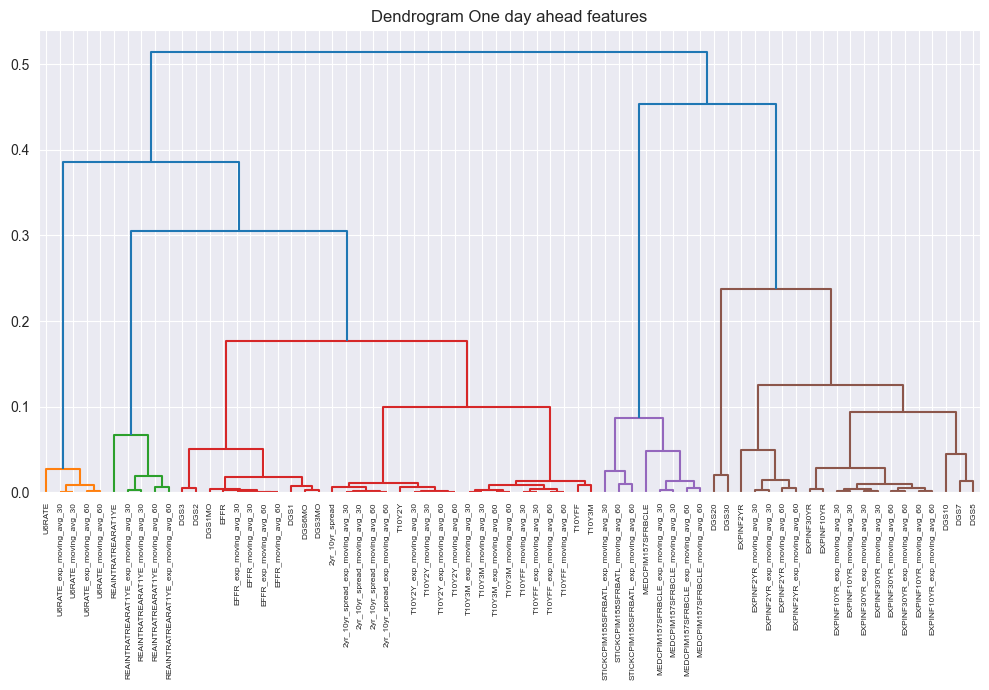

In [114]:
corr = bond_yields_train_shifted_30[thirty_day_ahead_correlated_features].corr().abs()
# get the distance
dist = 1 - corr
dist_condensed = squareform(dist)
linkage_matrix = linkage(dist_condensed, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, color_threshold=0.3, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram One day ahead features')
plt.tight_layout()
plt.show()

In [130]:
# out of the 5 groups get the features with the highest correlation
def get_correlated_clusters(df: pd.DataFrame, cols: list[str], threshold: float = 0.5) -> pd.DataFrame:
    """
    Get the clusters of correlated features. based on the specified threshold
    """
    corr = df[cols].corr().abs()
    dist = 1 - corr
    dist_condensed = squareform(dist, checks=False)
    linkage_matrix = linkage(dist_condensed, method='average')
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    return pd.DataFrame({'feature': cols, 'cluster': cluster_labels})

def feature_reduction(df1: pd.DataFrame, df2: pd.DataFrame, col_threshold: str) -> list[str]:
    """
    Get the max correlated feature in each cluster
    df1: cluster df
    df2: correlation df
    col_threshold: the threshold to use for the feature reduction in df2
    """
    grouped_features = df1.groupby('cluster')['feature'].apply(list)
    max_correlated_features = []
    for cluster, features in grouped_features.items():
        max_corr_feature = df2.loc[features][col_threshold].idxmax()
        max_correlated_features.append(max_corr_feature)
    # get the list of features not in max_correlated_features
    # other_features = [feature for feature in df2.index if feature not in max_correlated_features]

    return max_correlated_features



In [131]:
df_cluster = get_correlated_clusters(bond_yields_train_shifted_1, one_day_ahead_correlated_features, threshold=0.3)
max_correlated_features1 = feature_reduction(df_cluster, df_correlation1_avg, col_threshold='correlation_avg')

df_cluster = get_correlated_clusters(bond_yields_train_shifted_7, seven_day_ahead_correlated_features, threshold=0.3)
max_correlated_features7 = feature_reduction(df_cluster, df_correlation7_avg, col_threshold='correlation_avg')

df_cluster = get_correlated_clusters(bond_yields_train_shifted_30, thirty_day_ahead_correlated_features, threshold=0.3)
max_correlated_features30 = feature_reduction(df_cluster, df_correlation30_avg, col_threshold='correlation_avg')

df_cluster = get_correlated_clusters(bond_yields_train_shifted_60, sixty_day_ahead_correlated_features, threshold=0.3)
max_correlated_features60 = feature_reduction(df_cluster, df_correlation60_avg, col_threshold='correlation_avg')

print(f"Max correlated features 1 day ahead: {max_correlated_features1}")
print(f"Max correlated features 7 day ahead: {max_correlated_features7}")
print(f"Max correlated features 30 day ahead: {max_correlated_features30}")
print(f"Max correlated features 60 day ahead: {max_correlated_features60}")

Max correlated features 1 day ahead: ['U6RATE', 'REAINTRATREARAT1YE_exp_moving_avg_60', 'DGS3', 'MEDCPIM157SFRBCLE_moving_avg_60', 'DGS5']
Max correlated features 7 day ahead: ['U6RATE', 'REAINTRATREARAT1YE_exp_moving_avg_60', 'DGS3', 'MEDCPIM157SFRBCLE_moving_avg_60', 'DGS5']
Max correlated features 30 day ahead: ['U6RATE', 'REAINTRATREARAT1YE_exp_moving_avg_60', 'DGS3', 'MEDCPIM157SFRBCLE_exp_moving_avg_60', 'DGS5']
Max correlated features 60 day ahead: ['U6RATE', 'REAINTRATREARAT1YE_exp_moving_avg_30', 'DGS3', 'MEDCPIM157SFRBCLE_exp_moving_avg_60', 'DGS5']


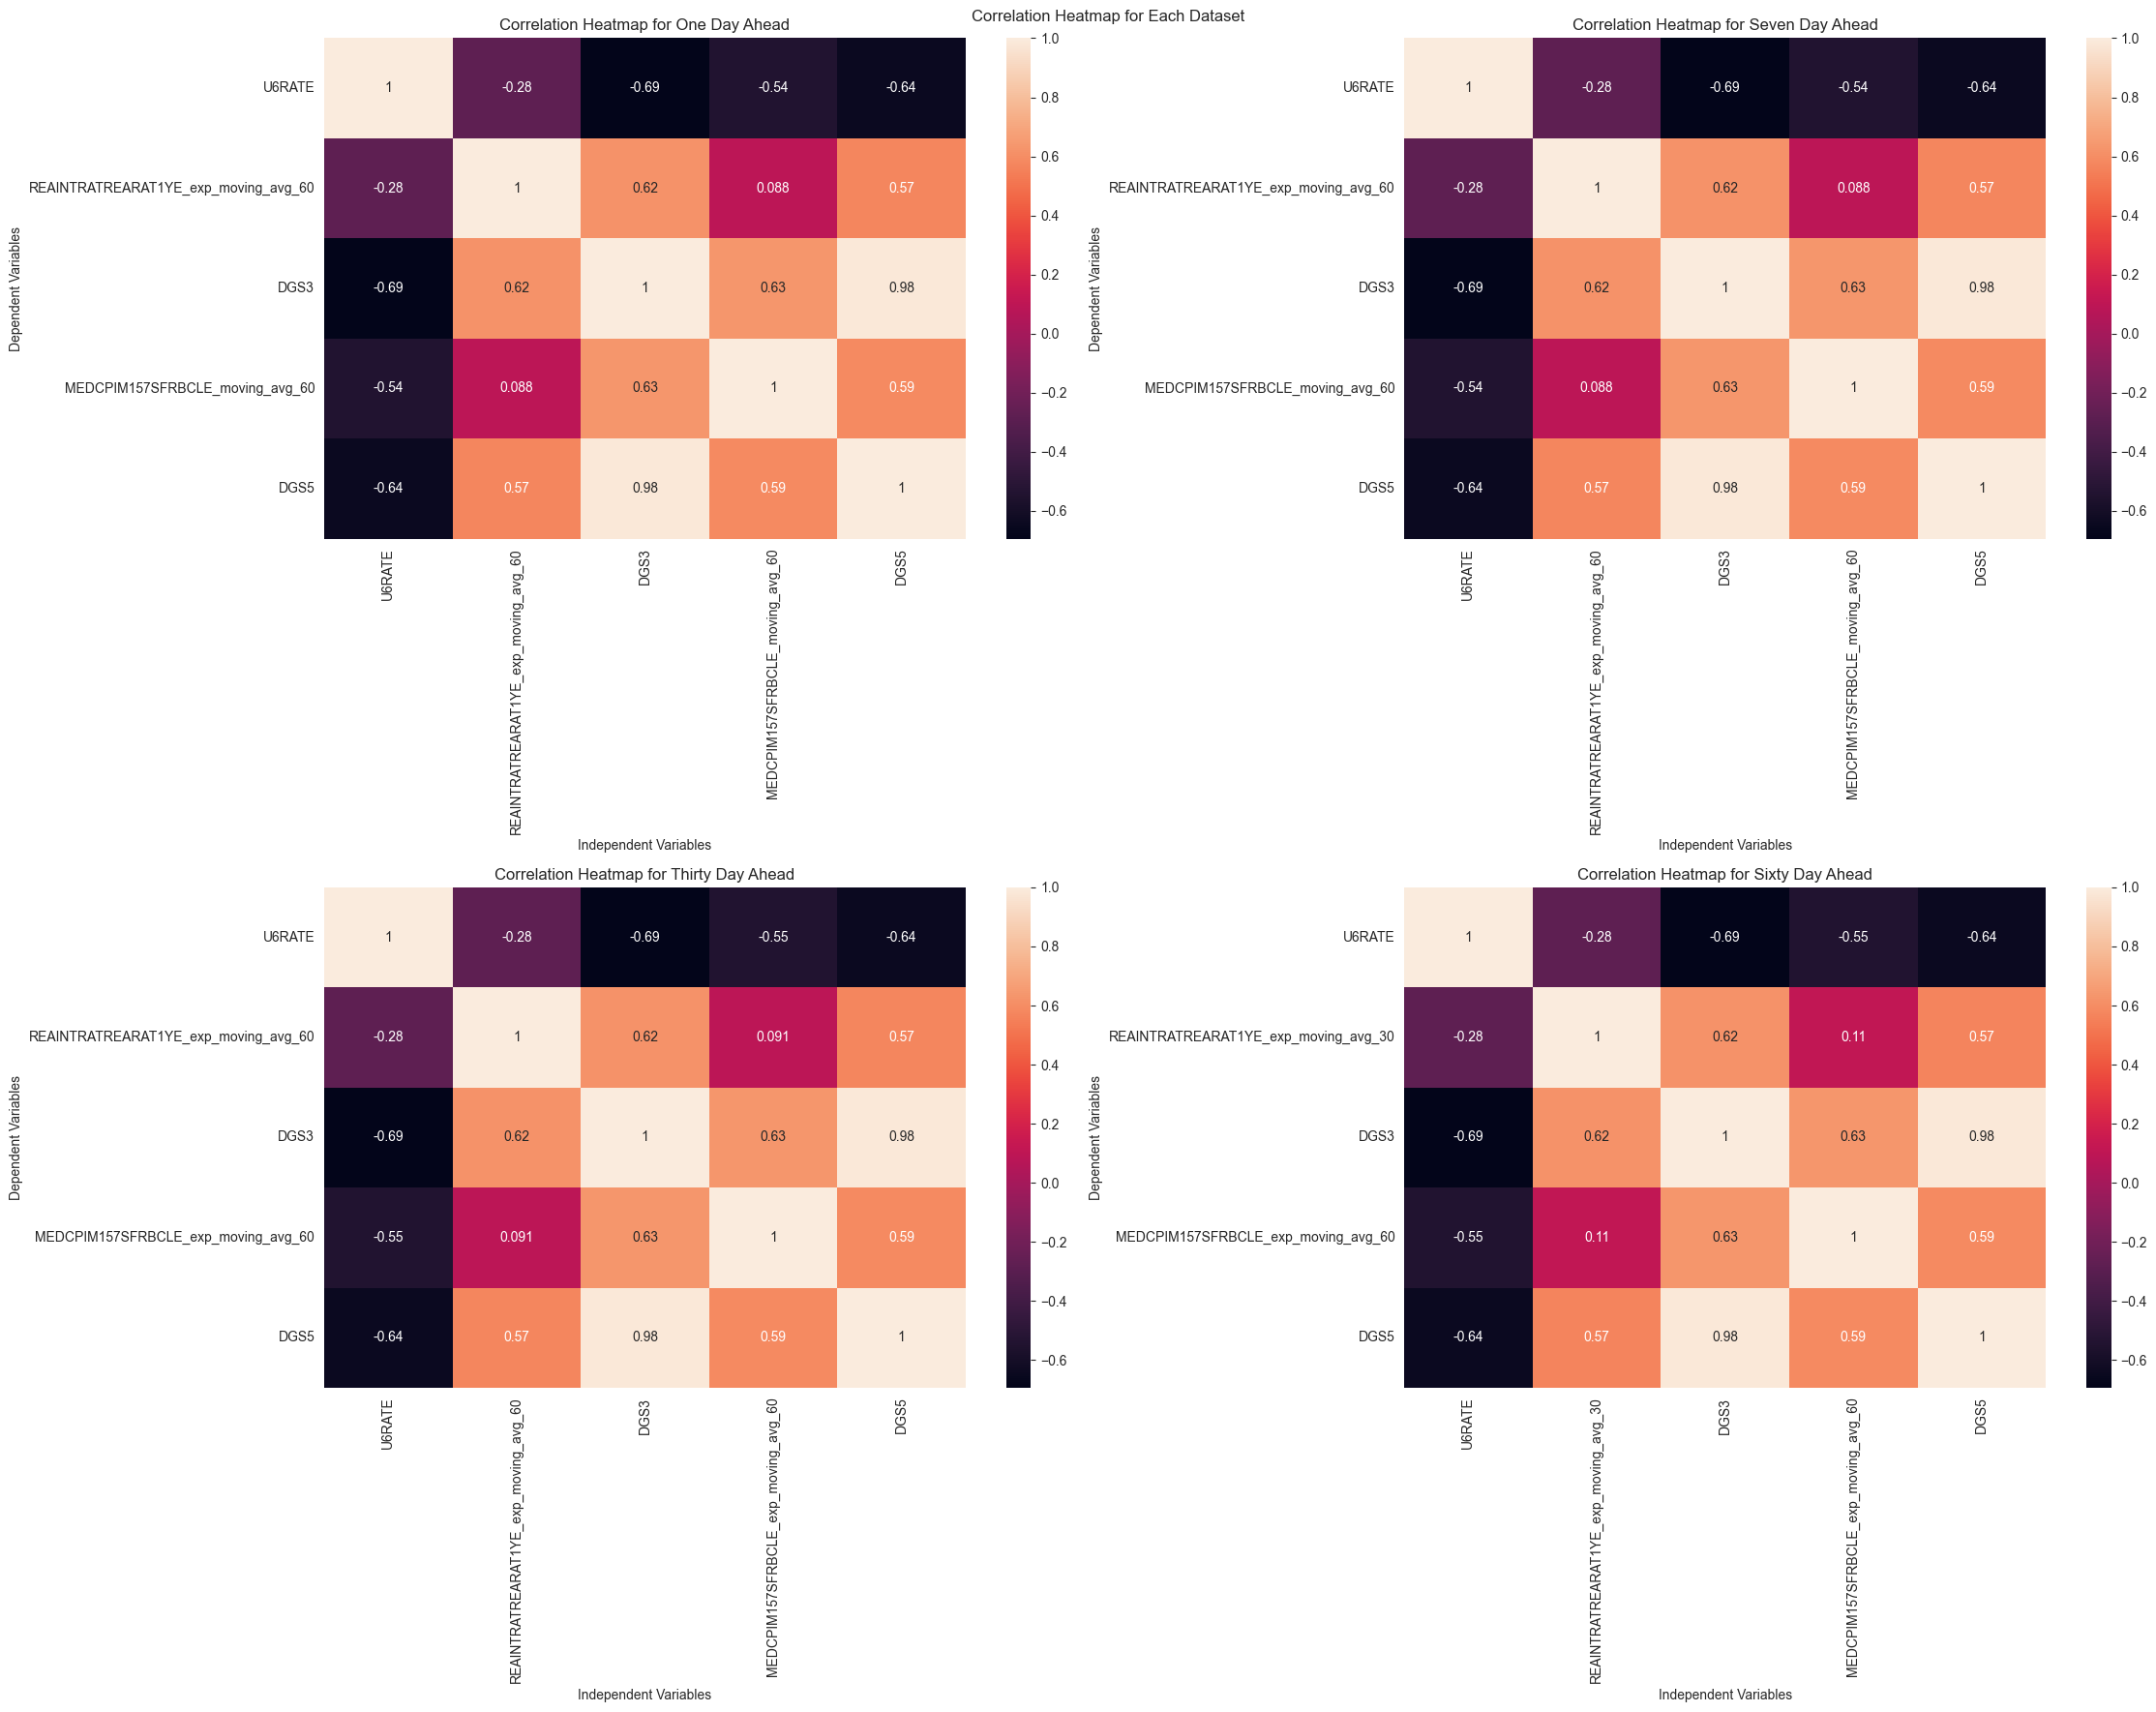

In [133]:
# plot the correlation heatmap of the for each datasets' independent variables
data_sets = [bond_yields_train_shifted_1, bond_yields_train_shifted_7, bond_yields_train_shifted_30, bond_yields_train_shifted_60]
correlated_features = [max_correlated_features1, max_correlated_features7, max_correlated_features30, max_correlated_features60]
titles = ['One Day Ahead', 'Seven Day Ahead', 'Thirty Day Ahead', 'Sixty Day Ahead']
fig, axes = plt.subplots(2, 2, figsize=(23, 18))
axes = axes.flatten()
for i, data in enumerate(zip(data_sets, correlated_features, titles)):
    data_vals = data[0]
    ind_cols = data[1]
    title = data[2]
    cor_vals = data_vals[ind_cols].corr()
    sns.heatmap(cor_vals, annot=True, ax=axes[i])
    axes[i].set_title(f'Correlation Heatmap for {title}')
    axes[i].set_xlabel('Independent Variables')
    axes[i].set_ylabel('Dependent Variables')
plt.suptitle('Correlation Heatmap for Each Dataset')
plt.tight_layout()

In [137]:
features_selected_dict = {
    'one-day-ahead': {'max_features': max_correlated_features1},
    'seven-day-ahead': {'max_features': max_correlated_features7},
    'thirty-day-ahead': {'max_features': max_correlated_features30},
    'sixty-day-ahead': {'max_features': max_correlated_features60},
    'dependent_variables': dependent_variables
}

# write the dict to a yaml file
with open('data/features_selected2.yaml', 'w') as f:
    f.write(json.dumps(features_selected_dict, indent=4))
    f.close()
print(f"Features selected saved to features_selected.yaml")

Features selected saved to features_selected.yaml


In [139]:
# read in one of the sample data
sample_file = 'results/one-day-ahead/samples/dgs_yields/percentile/2024-12-16.parquet'
df_sample = pd.read_parquet(sample_file)
df_sample.head()

,DGS1MO_future_val,DGS3MO_future_val,DGS6MO_future_val,DGS1_future_val,DGS2_future_val,DGS3_future_val,DGS5_future_val,DGS7_future_val,DGS10_future_val,DGS20_future_val,...,DGS3MO_future_val_percentile,DGS6MO_future_val_percentile,DGS1_future_val_percentile,DGS2_future_val_percentile,DGS3_future_val_percentile,DGS5_future_val_percentile,DGS7_future_val_percentile,DGS10_future_val_percentile,DGS20_future_val_percentile,DGS30_future_val_percentile
0,4.513885,4.431342,4.480327,4.765594,4.864241,4.856035,4.856477,4.933631,4.971919,5.251705,...,0.286,0.498,0.812,0.912,0.948,0.957,0.967,0.980,0.986,0.982
1,5.026576,5.030429,5.076915,4.973467,4.867978,4.710844,4.588040,4.583982,4.552623,4.729854,...,0.882,0.925,0.906,0.914,0.894,0.840,0.806,0.731,0.600,0.572
2,4.758419,4.762210,4.683278,4.681886,4.598115,4.460798,4.420126,4.453400,4.470049,4.692654,...,0.653,0.713,0.743,0.775,0.730,0.696,0.676,0.638,0.557,0.569
3,4.873115,4.781363,4.681398,4.494167,4.346595,4.228581,4.202263,4.246977,4.288511,4.569623,...,0.680,0.709,0.619,0.559,0.500,0.439,0.417,0.377,0.349,0.333
4,4.384289,4.274134,3.935555,3.650803,3.507592,3.533856,3.676813,3.803832,3.988090,4.364755,...,0.147,0.088,0.048,0.038,0.043,0.052,0.061,0.081,0.120,0.174
